In [1]:
import os
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import glob
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf


In [2]:
c=0
print(os.getcwd())
for root, directories, filenames in os.walk('./roof_images'):
    for files in filenames:
        c=c+1
print(c)

E:\alaki
42759


In [3]:
import glob
import cv2 as cv

path = glob.glob("./roof_images/*.jpg")
cv_img = []
for img in path:
    n = cv.imread(img)
    cv_img.append(n)

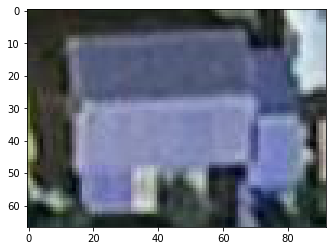

In [4]:
plt.imshow(cv_img[1000])

## Using resized images

In [5]:
import glob
import cv2 as cv

path = glob.glob("E:/alaki/resized/roof_images/*.jpg")
resized_images = []
for img in path:
    n = cv.imread(img)
    resized_images.append(n)

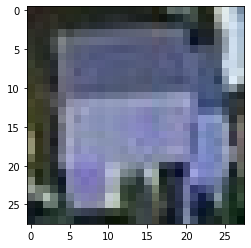

In [6]:
plt.imshow(resized_images[1000])

## We'll start simple, with a single fully-connected neural layer as encoder and as decoder:



In [9]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 2352 floats

# this is our input placeholder
input_img = Input(shape=(2352,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(2352, activation='sigmoid')(encoded)                       #change it to rele activation fuction

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


## Let's also create a separate encoder model:



In [11]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## As well as the decoder model:



In [12]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Now let's train our autoencoder to reconstruct images.

### First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [14]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


## Let's prepare our input data. we're only interested in encoding/decoding the input images.



In [15]:
import numpy as np
resized_images=np.array(resized_images)


In [17]:
x_train, x_test = train_test_split(resized_images, test_size=0.30)

## We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors.

In [18]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [21]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)


(29931, 2352)
(12828, 2352)


## Now let's train our autoencoder for 100 epochs:



In [25]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 29931 samples, validate on 12828 samples
Epoch 1/50
29931/29931 [==============================] - 16s 532us/step - loss: 0.6211 - val_loss: 0.6196
Epoch 2/50
29931/29931 [==============================] - 13s 450us/step - loss: 0.6219 - val_loss: 0.6212
Epoch 3/50
29931/29931 [==============================] - 13s 420us/step - loss: 0.6224 - val_loss: 0.6187ETA: - ETA: 0s - loss: 0.622
Epoch 4/50
29931/29931 [==============================] - 13s 431us/step - loss: 0.6210 - val_loss: 0.6195
Epoch 5/50
29931/29931 [==============================] - 14s 459us/step - loss: 0.6215 - val_loss: 0.6180
Epoch 6/50
29931/29931 [==============================] - 12s 418us/step - loss: 0.6199 - val_loss: 0.6247
Epoch 7/50
29931/29931 [==============================] - 15s 491us/step - loss: 0.6226 - val_loss: 0.6191
Epoch 8/50
29931/29931 [==============================] - 14s 474us/step - loss: 0.6216 - val_loss: 0.6177
Epoch 9/50
29931/29931 [==============================] - 13s 420u

## We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [23]:
# encode and decode some images
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


<function matplotlib.pyplot.show(*args, **kw)>

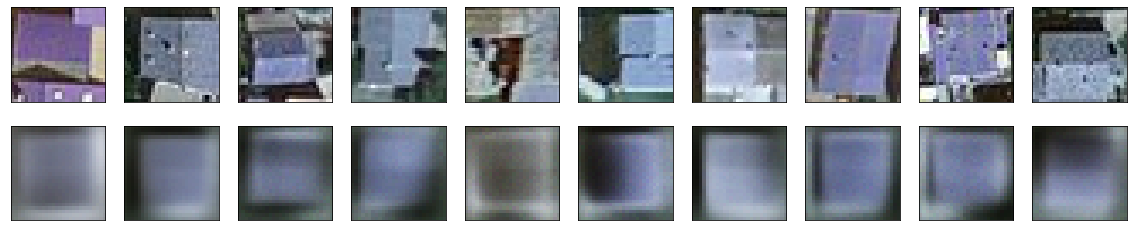

In [24]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show